# Forest Cover Type — EDA Notebook (Aligned with Report)
Run this notebook to generate all visuals referenced in the LaTeX report.

## 1. Load Dataset

In [4]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

sns.set(style="whitegrid", rc={"figure.figsize":(10,5)})

df = pd.read_csv("covtype.csv")
df.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## 2. Class Distribution

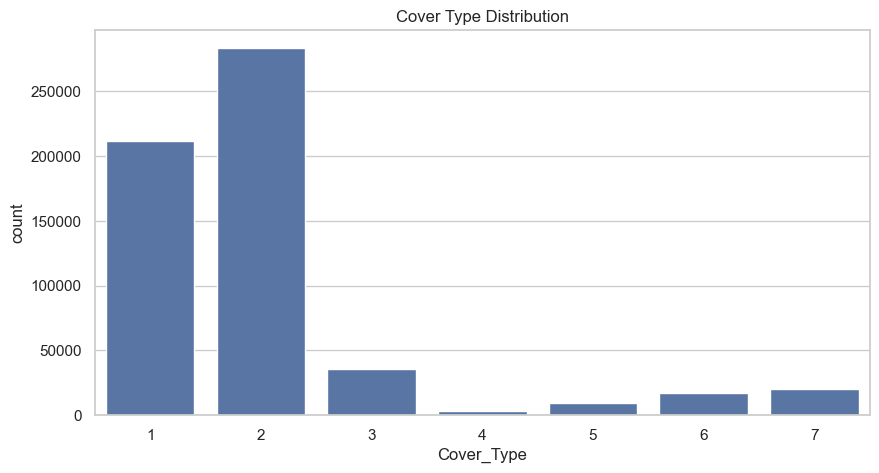

In [5]:

sns.countplot(x='Cover_Type', data=df, order=sorted(df['Cover_Type'].unique()))
plt.title("Cover Type Distribution")
plt.show()


## 3. Continuous Feature Behavior

In [6]:

continuous=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
            'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
            'Horizontal_Distance_To_Fire_Points','Hillshade_9am','Hillshade_Noon',
            'Hillshade_3pm']

stats_df=df[continuous].agg(['mean','std','min','max']).T
stats_df['skew']=df[continuous].skew().values
stats_df


,mean,std,min,max,skew
Elevation,2959.365301,279.984734,1859.0,3858.0,-0.817596
Aspect,155.656807,111.913721,0.0,360.0,0.402628
Slope,14.103704,7.488242,0.0,66.0,0.789273
Horizontal_Distance_To_Hydrology,269.428217,212.549356,0.0,1397.0,1.140437
Vertical_Distance_To_Hydrology,46.418855,58.295232,-173.0,601.0,1.790250
Horizontal_Distance_To_Roadways,2350.146611,1559.254870,0.0,7117.0,0.713679
Horizontal_Distance_To_Fire_Points,1980.291226,1324.195210,0.0,7173.0,1.288644
Hillshade_9am,212.146049,26.769889,0.0,254.0,-1.181147
Hillshade_Noon,223.318716,19.768697,0.0,254.0,-1.063056
Hillshade_3pm,142.528263,38.274529,0.0,254.0,-0.277053


### 3.1 Most Skewed Features

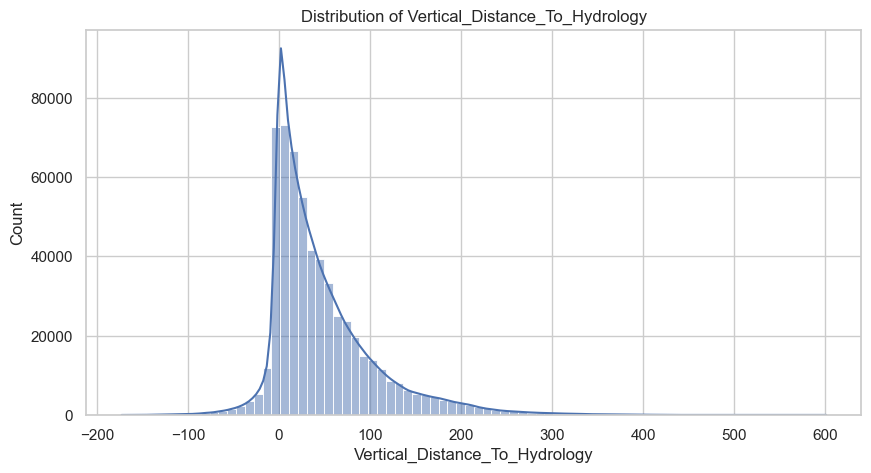

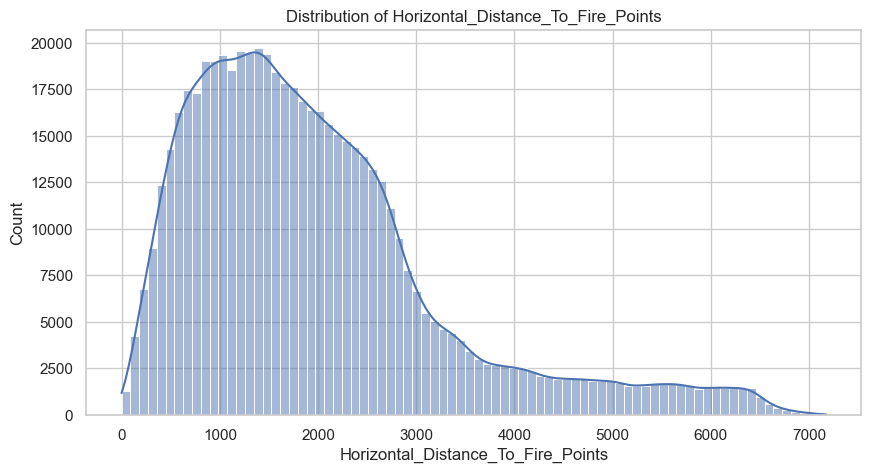

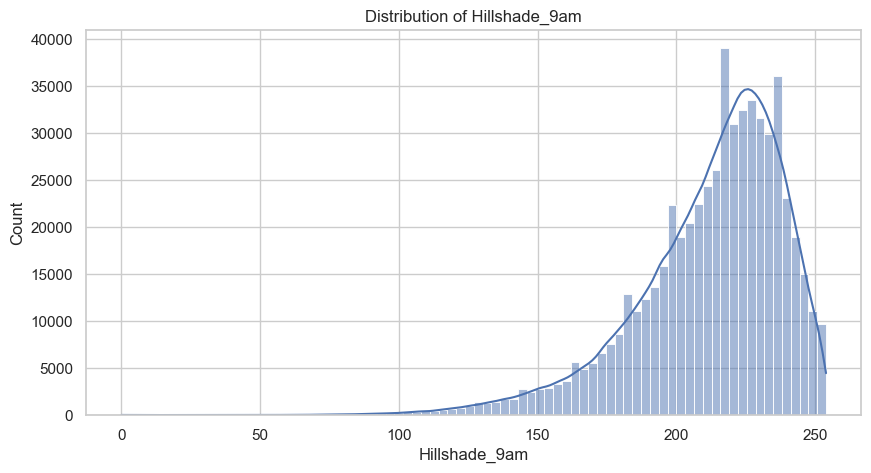

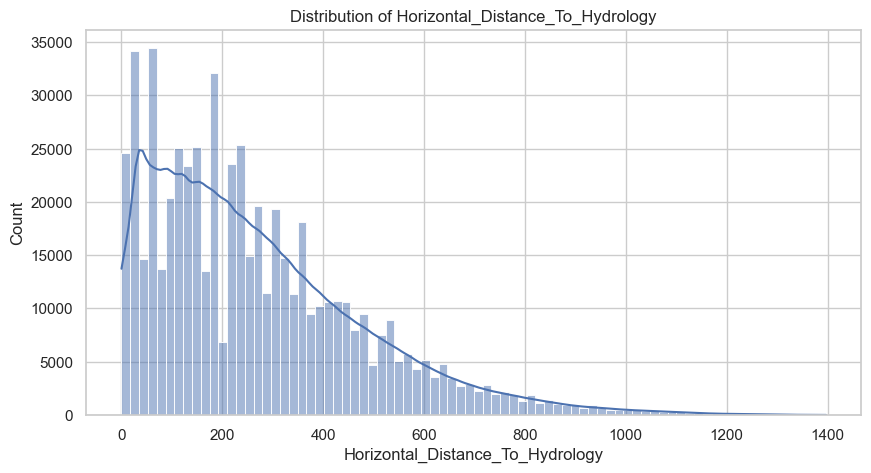

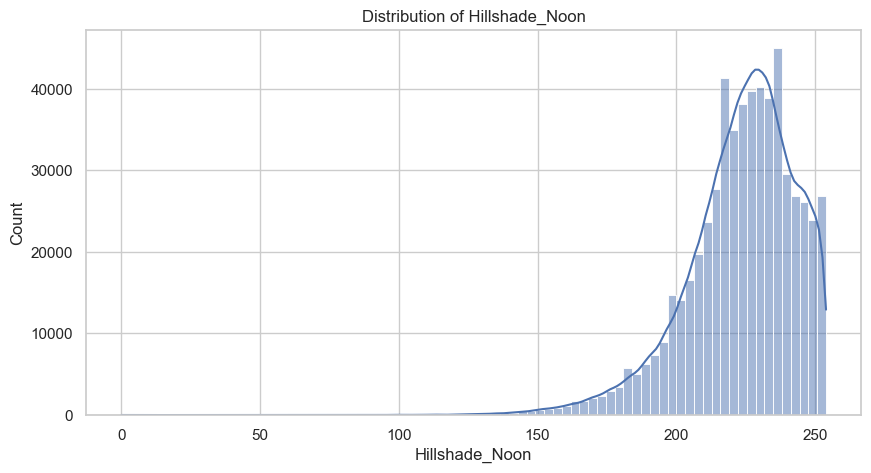

In [7]:

skewed=stats_df['skew'].abs().sort_values(ascending=False).head(5).index.tolist()
for col in skewed:
    sns.histplot(df[col], bins=80, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


## 4. Elevation & Slope Across Cover Types

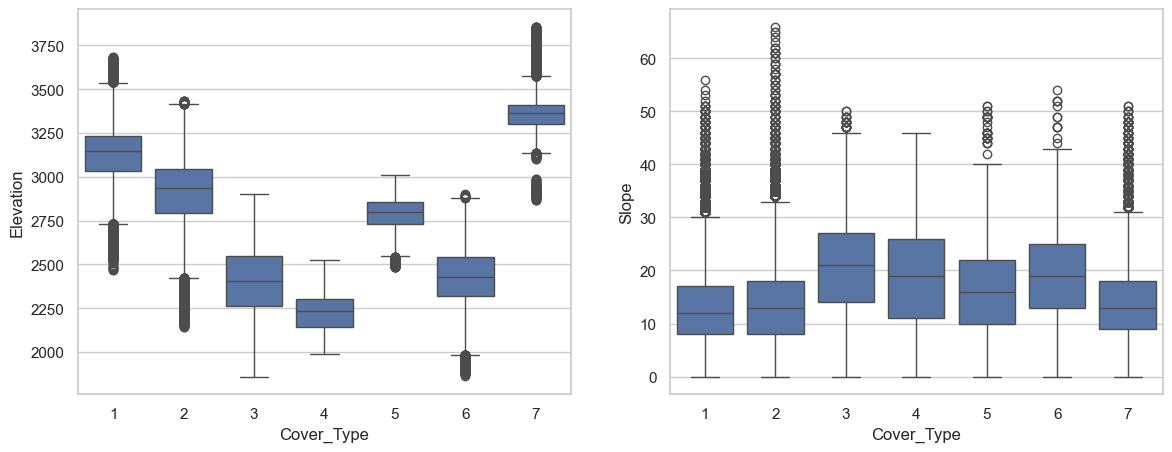

In [8]:

fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.boxplot(x='Cover_Type',y='Elevation',data=df,ax=ax[0])
sns.boxplot(x='Cover_Type',y='Slope',data=df,ax=ax[1])
plt.show()


## 5. Elevation vs Hydrology Distance

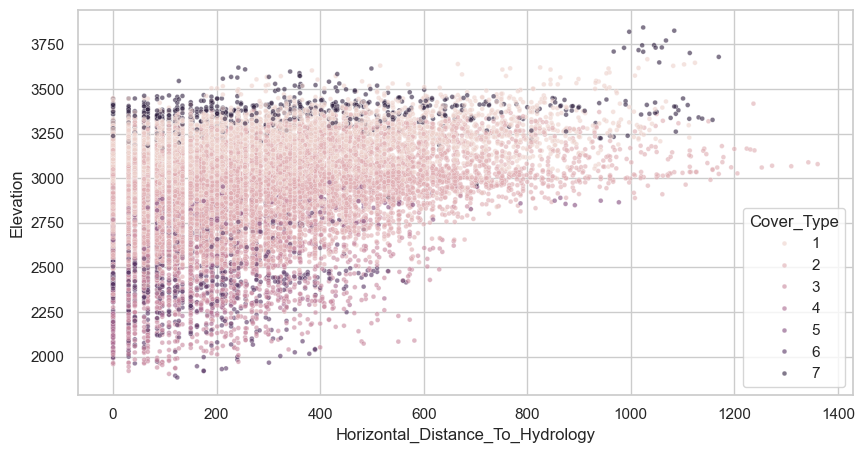

In [9]:

sample=df.sample(20000,random_state=42)
sns.scatterplot(data=sample, x='Horizontal_Distance_To_Hydrology',
                y='Elevation', hue='Cover_Type', s=12, alpha=0.6)
plt.show()


## 6. Soil Type Heatmap

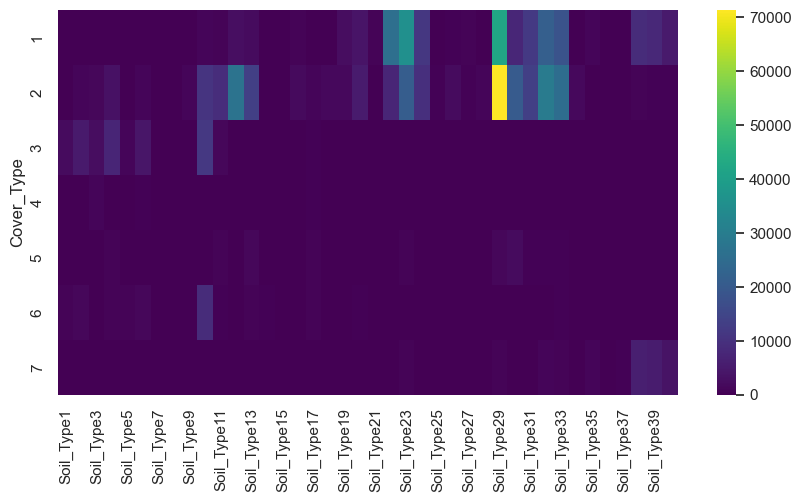

In [10]:

soil=[c for c in df.columns if 'Soil_Type' in c]
heat=df.groupby('Cover_Type')[soil].sum()
sns.heatmap(heat, cmap="viridis")
plt.show()


## 7. Mutual Information Ranking

In [11]:

X=df.drop(columns=['Cover_Type'])
y=df['Cover_Type']

mi = mutual_info_classif(X,y,random_state=42)
mi_series=pd.Series(mi,index=X.columns).sort_values(ascending=False)
mi_series.head(20)


Elevation                             0.457709
Wilderness_Area4                      0.147017
Wilderness_Area1                      0.103365
Horizontal_Distance_To_Roadways       0.089177
Horizontal_Distance_To_Fire_Points    0.069493
Soil_Type10                           0.065178
Slope                                 0.038683
Soil_Type29                           0.037497
Wilderness_Area3                      0.036201
Hillshade_9am                         0.031714
Soil_Type39                           0.029041
Soil_Type38                           0.028900
Soil_Type4                            0.027544
Soil_Type22                           0.025102
Soil_Type12                           0.024997
Horizontal_Distance_To_Hydrology      0.024709
Soil_Type2                            0.023149
Hillshade_Noon                        0.022984
Soil_Type23                           0.022966
Hillshade_3pm                         0.022836
dtype: float64

## 8. Random Forest EDA Feature Importance

In [12]:

sample=df.sample(40000, random_state=42)
X_s=sample.drop(columns=['Cover_Type'])
y_s=sample['Cover_Type']

rf=RandomForestClassifier(n_estimators=100,max_depth=12,n_jobs=-1)
rf.fit(X_s,y_s)

imp=pd.Series(rf.feature_importances_, index=X_s.columns).sort_values(ascending=False)
imp.head(20)


Elevation                             0.348930
Wilderness_Area4                      0.069875
Horizontal_Distance_To_Roadways       0.066848
Horizontal_Distance_To_Fire_Points    0.056200
Horizontal_Distance_To_Hydrology      0.031526
Soil_Type22                           0.031241
Hillshade_Noon                        0.029629
Aspect                                0.028565
Soil_Type12                           0.027550
Vertical_Distance_To_Hydrology        0.027279
Hillshade_9am                         0.023989
Hillshade_3pm                         0.023258
Soil_Type10                           0.021489
Slope                                 0.020641
Soil_Type4                            0.020460
Soil_Type38                           0.020203
Wilderness_Area3                      0.019592
Wilderness_Area1                      0.019113
Soil_Type23                           0.018632
Soil_Type2                            0.018207
dtype: float64

## 9. PCA Visualization

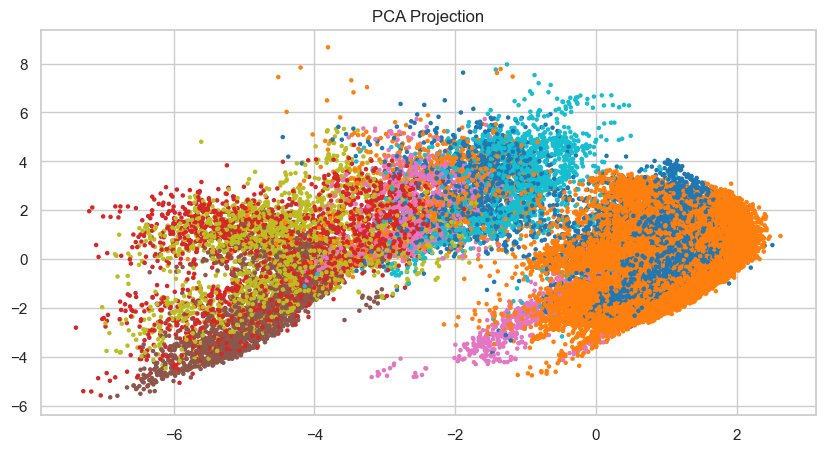

In [13]:

scaler=StandardScaler()
scaled=scaler.fit_transform(df.drop(columns=['Cover_Type']).iloc[:50000])

pca=PCA(n_components=2)
proj=pca.fit_transform(scaled)

plt.scatter(proj[:,0], proj[:,1], c=df['Cover_Type'][:50000], cmap='tab10', s=5)
plt.title("PCA Projection")
plt.show()


## 10. t-SNE Projection

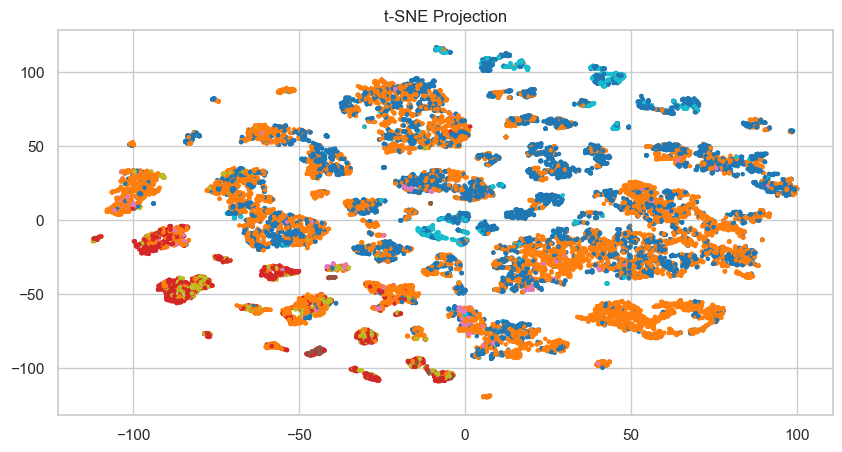

In [14]:

idx=np.random.choice(df.index, size=25000, replace=False)
X_sample=df.drop(columns=['Cover_Type']).loc[idx]
y_sample=df.loc[idx,'Cover_Type']

scaled=StandardScaler().fit_transform(X_sample)

tsne=TSNE(n_components=2,perplexity=40,learning_rate='auto',init='pca')
emb=tsne.fit_transform(scaled)

plt.scatter(emb[:,0],emb[:,1],c=y_sample,cmap='tab10',s=5)
plt.title("t-SNE Projection")
plt.show()


## 11. Hillshade Analysis

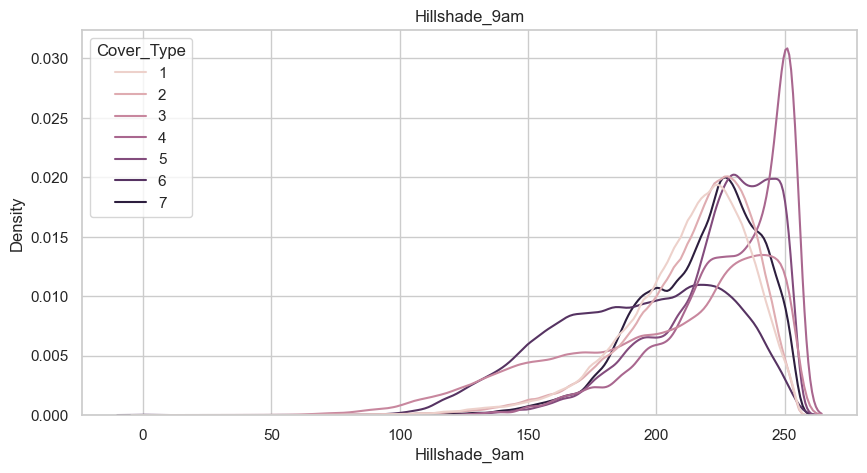

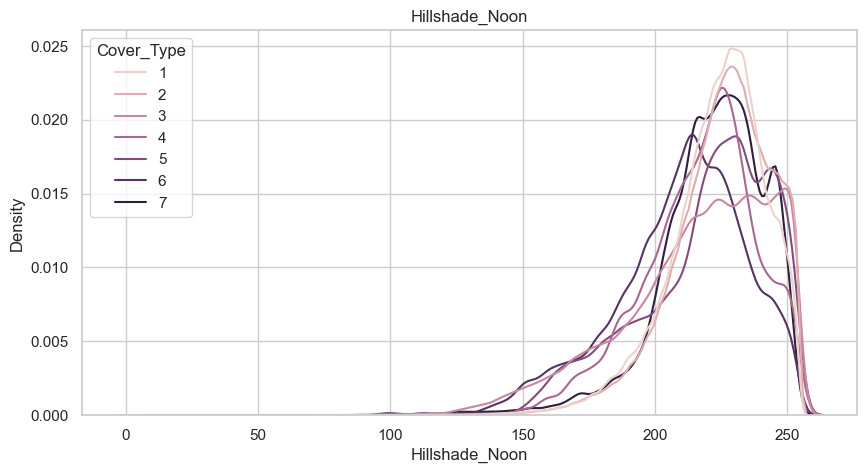

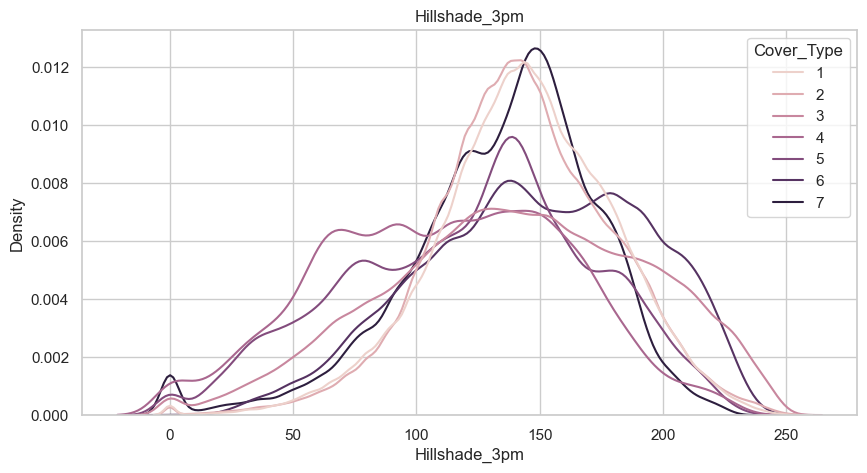

In [15]:

for col in ['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']:
    sns.kdeplot(data=df, x=col, hue='Cover_Type', bw_adjust=0.7, common_norm=False)
    plt.title(col)
    plt.show()


## 12. Correlation Matrix

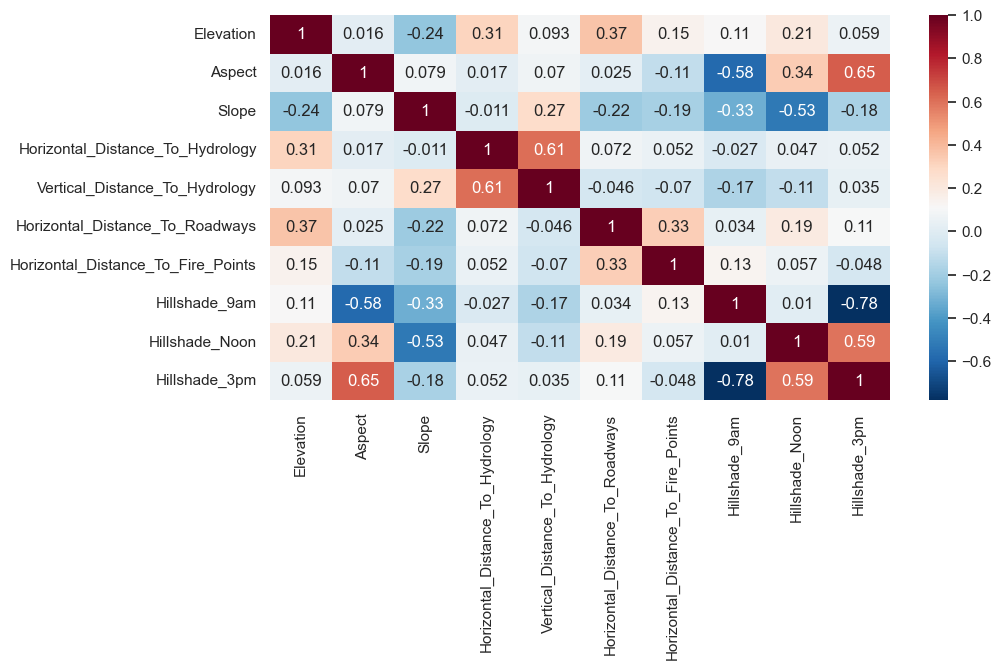

In [16]:

sns.heatmap(df[continuous].corr(), annot=True, cmap='RdBu_r')
plt.show()


## 13. Soil Count per Cover Type

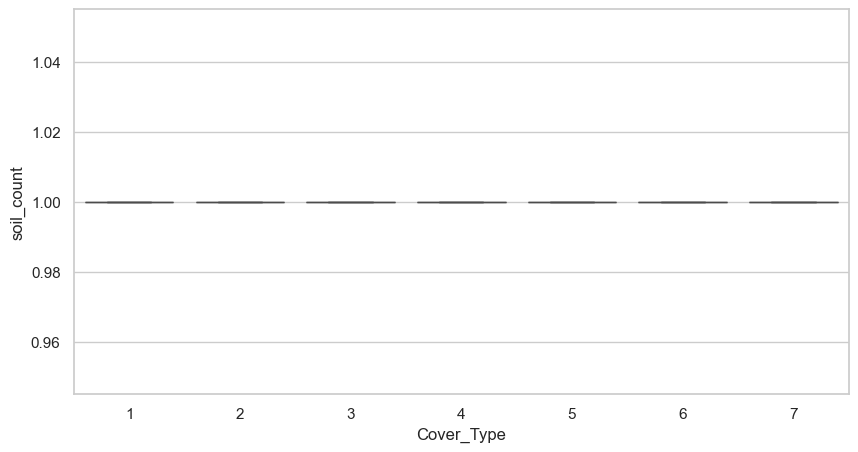

In [17]:

df['soil_count']=df[soil].sum(axis=1)
sns.boxplot(x='Cover_Type',y='soil_count',data=df.sample(30000))
plt.show()
